In [15]:
import os
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
from nilearn.glm.second_level import SecondLevelModel
from nilearn import datasets
from nilearn.plotting import plot_design_matrix
from nilearn.glm.first_level import make_first_level_design_matrix
import numpy as np

### Design Matrix

TR:  3.0


<Figure size 1200x600 with 0 Axes>

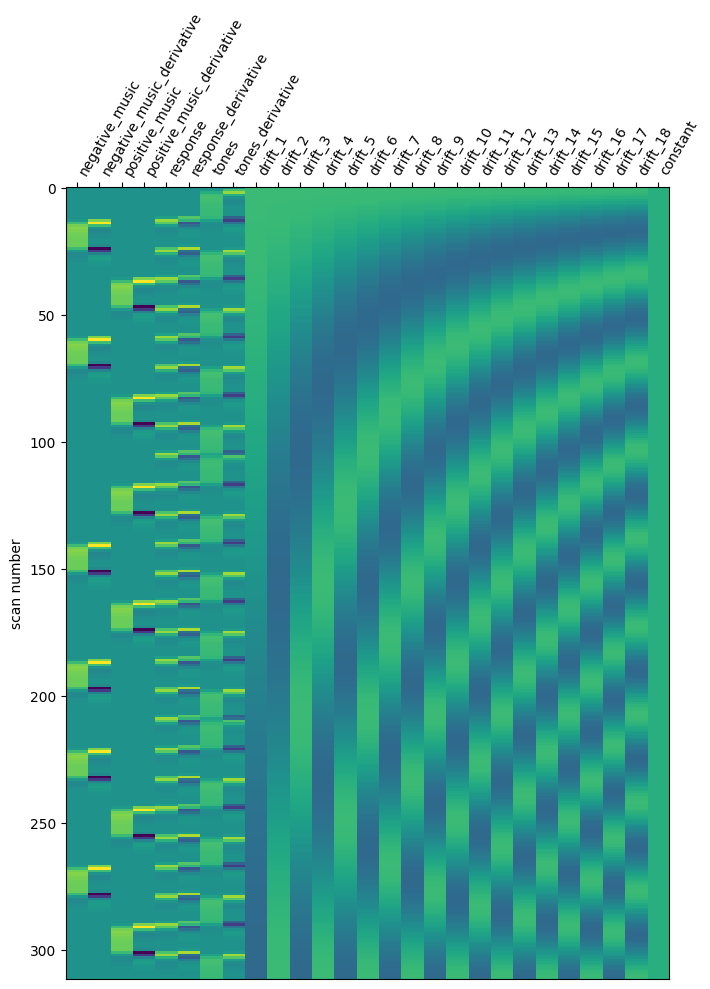

(312, 27)


In [16]:
# Define paths relative to the src folder
base_dir = os.path.join("..", "data", "raw","sub-control01")  # Navigate up one directory and then into data
preprocess_dir = os.path.join( "..","data", "preprocessed", "sub-control01")  # Preprocess folder
figures_dir = os.path.join("..", "results", "figures", "glm")  # Figures folder
results_dir = os.path.join("..", "results", "glm")

# Load the event files for each run
events = [
    pd.read_csv(os.path.join(base_dir, "func", "sub-control01_task-music_run-1_events.tsv"), sep="\t"),
    pd.read_csv(os.path.join(base_dir, "func", "sub-control01_task-music_run-2_events.tsv"), sep="\t"),
    pd.read_csv(os.path.join(base_dir, "func", "sub-control01_task-music_run-3_events.tsv"), sep="\t")
]

# Load the functional image to extract TR and run durations
img = nib.load(os.path.join(base_dir, "func", "sub-control01_task-music_run-1_bold.nii.gz"))
TR = img.header.get_zooms()[3]

print("TR: ", TR)
run_durations = [events[i]['onset'].iloc[-1] + events[i]['duration'].iloc[-1] for i in range(3)]



# Adjust onsets based on cumulative duration of previous runs
events[1]['onset'] += run_durations[0]
events[2]['onset'] += run_durations[0] + run_durations[1]

# Concatenate the events into a single DataFrame
all_events = pd.concat(events, ignore_index=True)
# Define the frame times for the entire concatenated session
total_duration = sum(run_durations)
frame_times = np.arange(0, total_duration, TR)

# Generate the design matrix
design_matrix = make_first_level_design_matrix(
    frame_times,
    all_events,
    hrf_model='spm + derivative'
)

# Save the design matrix as a CSV file
design_matrix.to_csv(os.path.join(results_dir, "design_matrix.csv"), index=False)

# Plot and save the design matrix
plt.figure(figsize=(12, 6))
plot_design_matrix(design_matrix)
plt.savefig(os.path.join(figures_dir, "design_matrix.png"))
plt.show()
plt.close()  # Close the figure to free memory
print(design_matrix.shape)

/Users/charlesboissier/miniforge3/envs/NSSP/lib/python3.11/site-packages/nilearn/image/resampling.py:809: UserWarning: Casting data from int32 to float32
  return resample_img(


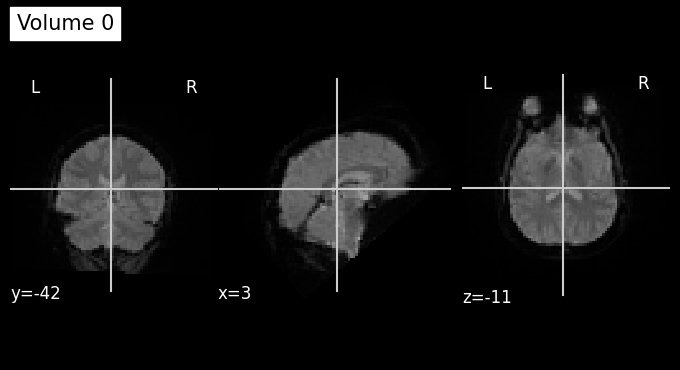

In [17]:
from nilearn import plotting

# Select the volume (e.g., first volume at index 0) using .slicer
volume_img = img.slicer[..., 0]

# Plot the selected 3D volume
plotting.plot_anat(volume_img, display_mode='ortho', title="Volume 0")
plotting.show()

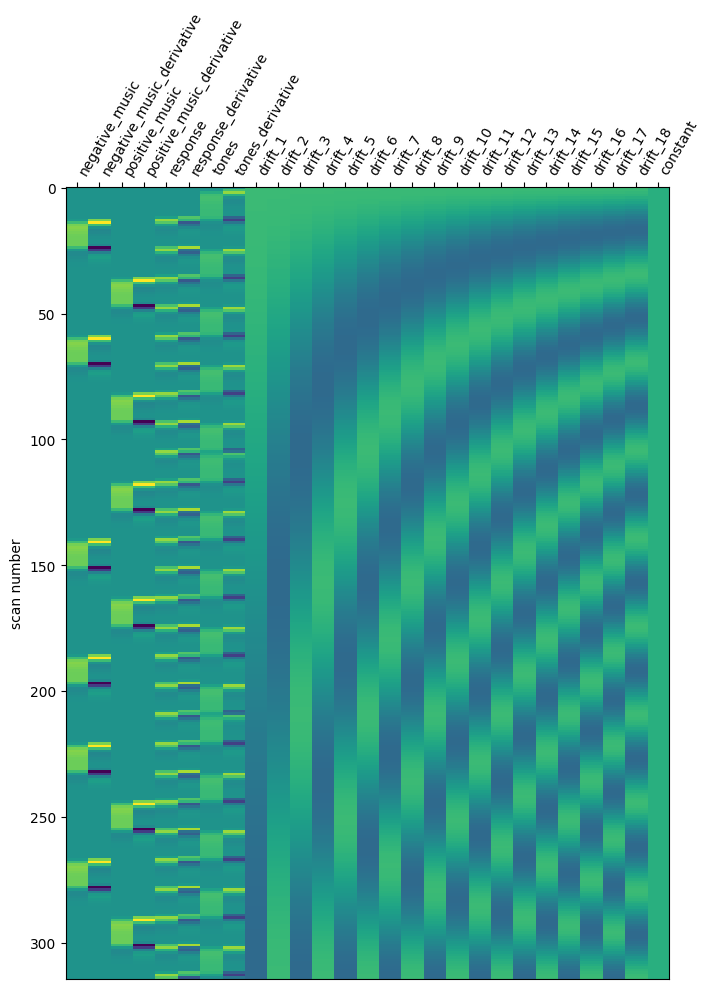

In [18]:
from nilearn.glm.first_level import FirstLevelModel

fmri_glm = FirstLevelModel(
    t_r=3,
    noise_model="ar1",
    standardize=False,
    hrf_model="spm + derivative",
    drift_model="cosine",
    high_pass=0.01,
)

img = nib.load(os.path.join("..", "data", "preprocessed", "sub-control01", "func", "preprocessed_data.nii.gz"))
fmri_glm = fmri_glm.fit(img,
    all_events,)

design_matrix = fmri_glm.design_matrices_[0]
plot_design_matrix(design_matrix)

plt.show()

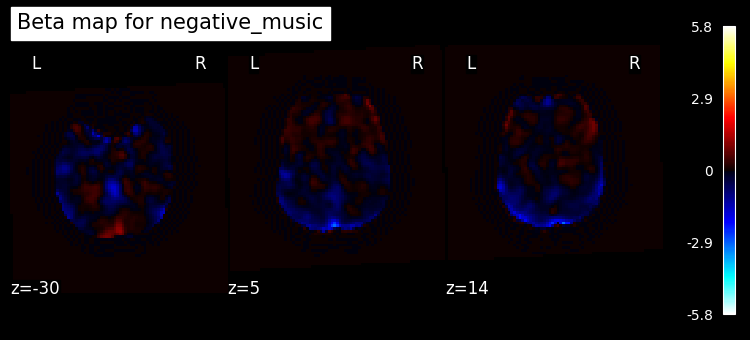

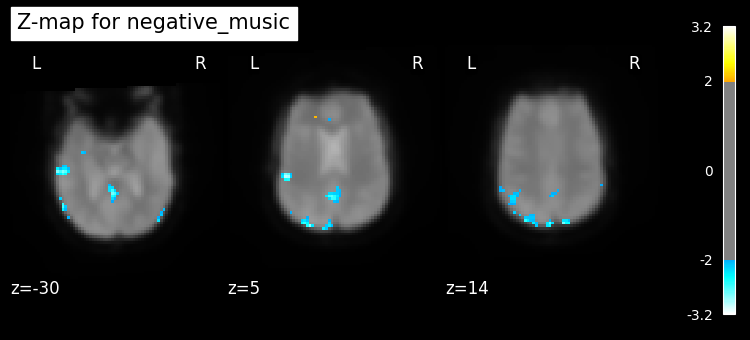

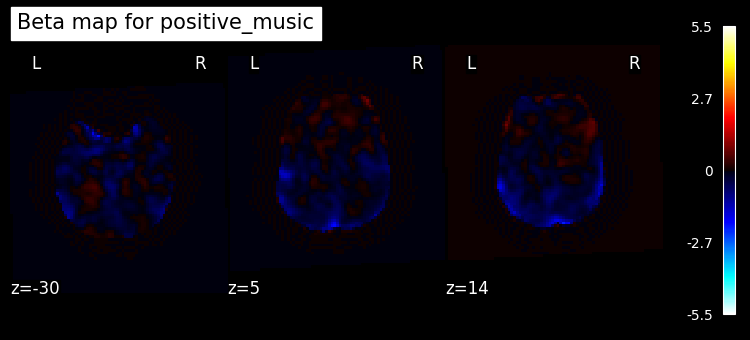

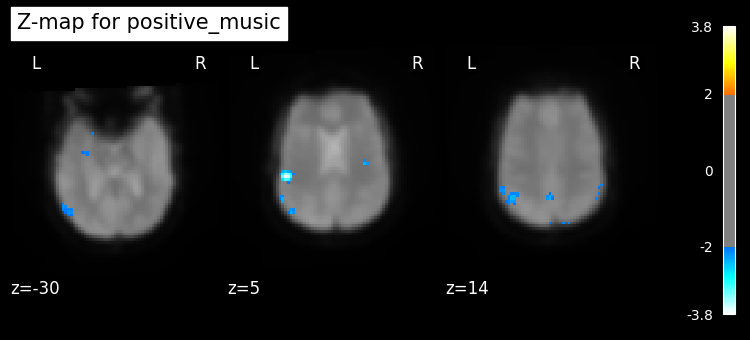

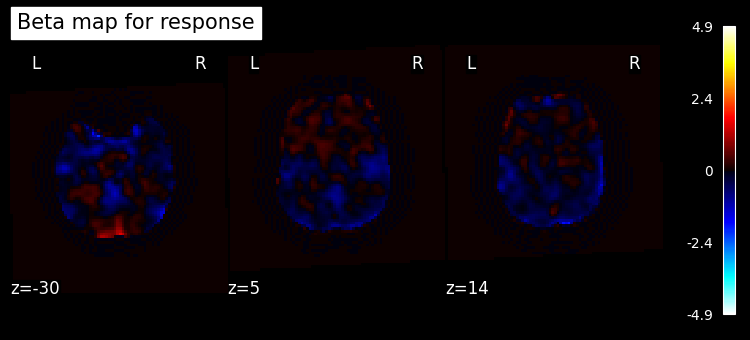

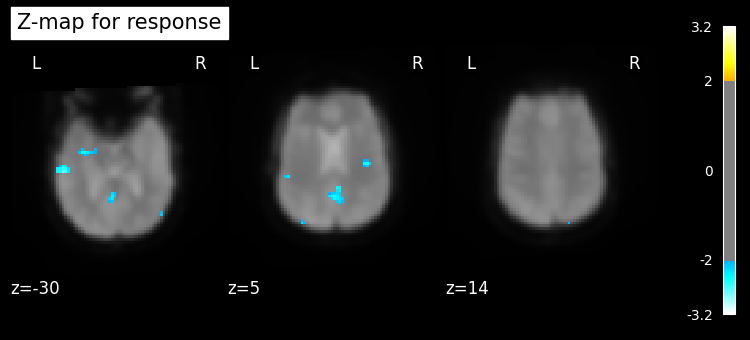

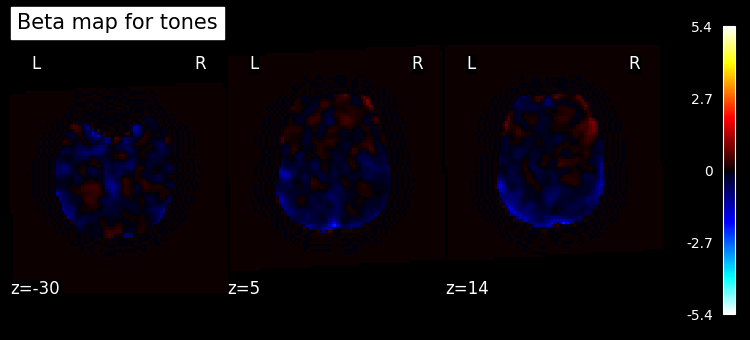

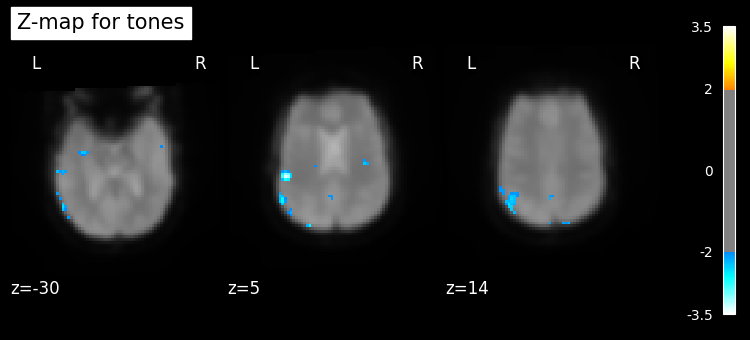

In [19]:
from nilearn.plotting import plot_anat, plot_img, plot_stat_map
from nilearn.image import concat_imgs, mean_img

mean_img = mean_img(img)
regressors = ['negative_music', 'positive_music', 'response', 'tones']

for regressor in regressors:
    # Create a contrast vector with a 1 for the current regressor and 0 for others
    contrast = np.zeros(len(design_matrix.columns))
    contrast[design_matrix.columns.get_loc(regressor)] = 1

    # Compute beta map and z-map for this contrast
    beta_map = fmri_glm.compute_contrast(contrast, output_type='effect_size')
    z_map = fmri_glm.compute_contrast(contrast, output_type='z_score')

    # Save the beta map and the z-map
    beta_map.to_filename(os.path.join(results_dir, f"beta_map_{regressor}.nii.gz"))
    z_map.to_filename(os.path.join(results_dir, f"z_map_{regressor}.nii.gz"))

    # Plot the beta map
    plot_stat_map(beta_map, bg_img=mean_img, threshold=0, display_mode='z', cut_coords=[-30, 5, 14], black_bg=True,
                  title=f'Beta map for {regressor}')
    plt.show()

    # Plot the Z-map
    plot_stat_map(z_map, bg_img=mean_img, threshold=2, display_mode='z', cut_coords=[-30, 5, 14], black_bg=True,
                  title=f'Z-map for {regressor}')
    plt.show()


The two first columns of the design matrix contain the expected response profile of regions which are sensitive to negative and positive music. Let’s plot them:

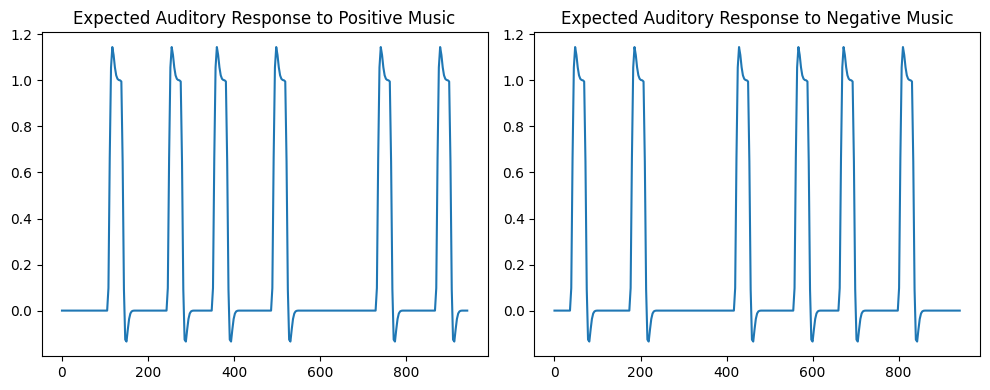

In [20]:
plt.figure(figsize=(10, 4))
output_dir = os.path.join("..", "results", "figures", "glm")  # Preprocess folder


# Top-left subplot (1,1) for negative music
plt.subplot(1,2,1)
plt.plot(design_matrix["positive_music"])
plt.title("Expected Auditory Response to Positive Music")

# Top-right subplot (1,2) for positive music
plt.subplot(1,2,2)
plt.plot(design_matrix["negative_music"])
plt.title("Expected Auditory Response to Negative Music")

plt.tight_layout() 
plt.savefig(os.path.join(output_dir, "auditory_response.png"))

plt.show()


### Detecting voxels with significant effects

In [21]:
conditions = {"negative_music": np.zeros(27), "positive_music": np.zeros(27)}
conditions["negative_music"][0] = 1
conditions["positive_music"][2] = 1

# We compare the conditions by defining the following contrast:
active_minus_rest = conditions["positive_music"] - conditions["negative_music"]

Design matrix shape: (315, 27)
Image shape: (80, 80, 50, 315)
Contrast vector shape: (27,)


<Axes: label='conditions'>

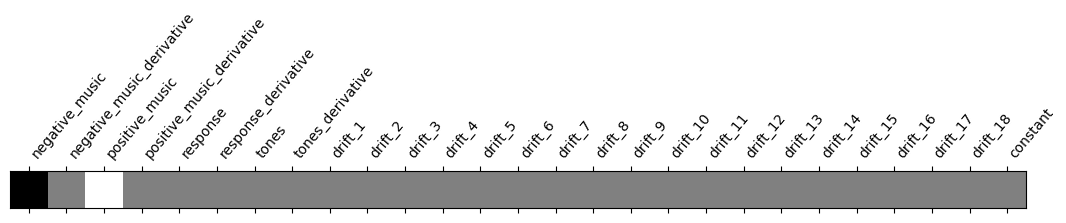

In [22]:
from nilearn.plotting import plot_contrast_matrix
print("Design matrix shape:", design_matrix.shape)
print("Image shape:", img.shape)
print("Contrast vector shape:", active_minus_rest.shape)

plot_contrast_matrix(active_minus_rest, design_matrix=design_matrix)

In [23]:
# In order to get statistical significance, we form a t-statistic and directly convert it to z-scale
z_map = fmri_glm.compute_contrast(active_minus_rest, output_type="z_score")

### Plot thresholded z-score map

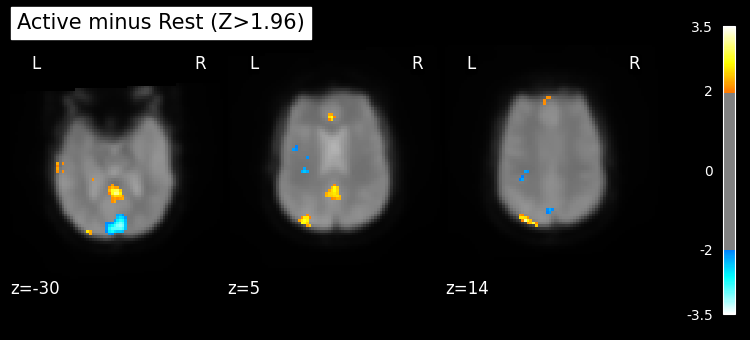

In [24]:
from nilearn.plotting import plot_anat, plot_img, plot_stat_map
from nilearn.image import concat_imgs, mean_img

mean_img = mean_img(img)

plot_stat_map(z_map, bg_img=mean_img, threshold=1.96,
              display_mode='z', cut_coords=[-30,5,14], black_bg=True,
              title='Active minus Rest (Z>1.96)')
plt.show()

In [25]:
output_dir = os.path.join("..", "results", "glm")  # Figure folder
os.makedirs(output_dir, exist_ok=True)

z_map_path = os.path.join(output_dir, "z_map.nii.gz")
mean_img_path = os.path.join(output_dir, "mean_img.nii.gz")

print(z_map_path)
z_map.to_filename(z_map_path)
mean_img.to_filename(mean_img_path)

../results/glm/z_map.nii.gz


To run in FSLeyes: fsleyes /home/eva/Docs/NSSP/nssp_miniproj_1/results/figures/mean_img.nii.gz         /home/eva/Docs/NS
SP/nssp_miniproj_1/results/figures/z_map.nii.gz --overlayType volume -cm red-yellow -dr 2 10

1.9599639845400545


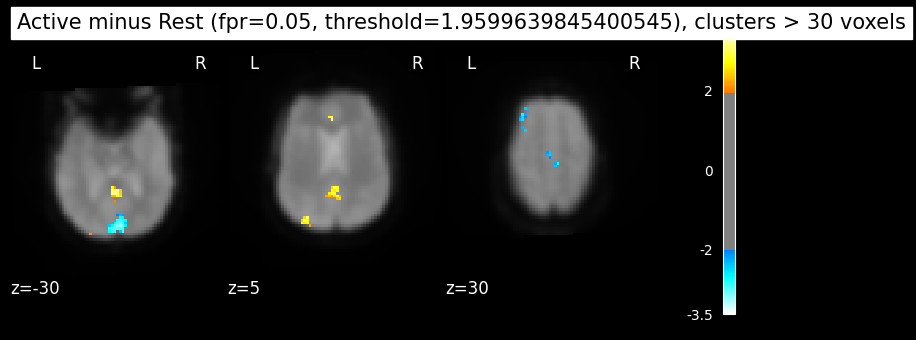

In [27]:
from nilearn.glm import threshold_stats_img

cluster_size = 30 
fdr_rate = 0.05 

# Here, we apply the FDR correction + threshold
clean_map, threshold = threshold_stats_img(z_map, alpha=fdr_rate, height_control='fpr', cluster_threshold=cluster_size)
print(threshold)
# And this is just to plot here!
plot_stat_map(clean_map, bg_img=mean_img, threshold=threshold,
              display_mode='z', cut_coords=[-30,5,30], black_bg=True,
              title='Active minus Rest (fpr={}, threshold={}), clusters > {} voxels'.format(fdr_rate, threshold, cluster_size))
plt.show()

In [28]:
clean_map_path = os.path.join(output_dir, "z_map_stat.nii.gz")

clean_map.to_filename(clean_map_path)

If we control the false positive rate (fpr, denoted by alpha) at a certain level, e.g. 0.001

In [29]:
from nilearn.datasets import fetch_atlas_aal
from nilearn.image import coord_transform, load_img
from nilearn.regions import connected_regions
from nilearn.maskers import NiftiLabelsMasker

z_data = z_map.get_fdata()

# Find the coordinates of the voxel with the maximum z-score
max_voxel_coords = np.unravel_index(np.argmax(z_data), z_data.shape)
max_z_value = np.max(z_data)
print(f"Max z-score: {max_z_value} at voxel coordinates: {max_voxel_coords}")

aal_atlas = fetch_atlas_aal()
aal_img = load_img(aal_atlas.maps)
aal_labels = aal_atlas.labels

affine = z_map.affine
mni_coords = coord_transform(*max_voxel_coords, affine)

# Create a masker for the AAL atlas
masker = NiftiLabelsMasker(aal_img, standardize=False)
aal_data = masker.fit_transform(z_map)

# Get the region label
region_index = np.argmax(aal_data)
region_label = aal_labels[region_index]

print(f"Maximal contrast region: {region_label} at coordinates {mni_coords}")
print(aal_labels)


Max z-score: 3.5448441537611775 at voxel coordinates: (np.int64(51), np.int64(29), np.int64(40))
Maximal contrast region: Vermis_7 at coordinates (-24.69091761112213, -93.43445514142513, 9.604300580918789)
['Precentral_L', 'Precentral_R', 'Frontal_Sup_L', 'Frontal_Sup_R', 'Frontal_Sup_Orb_L', 'Frontal_Sup_Orb_R', 'Frontal_Mid_L', 'Frontal_Mid_R', 'Frontal_Mid_Orb_L', 'Frontal_Mid_Orb_R', 'Frontal_Inf_Oper_L', 'Frontal_Inf_Oper_R', 'Frontal_Inf_Tri_L', 'Frontal_Inf_Tri_R', 'Frontal_Inf_Orb_L', 'Frontal_Inf_Orb_R', 'Rolandic_Oper_L', 'Rolandic_Oper_R', 'Supp_Motor_Area_L', 'Supp_Motor_Area_R', 'Olfactory_L', 'Olfactory_R', 'Frontal_Sup_Medial_L', 'Frontal_Sup_Medial_R', 'Frontal_Med_Orb_L', 'Frontal_Med_Orb_R', 'Rectus_L', 'Rectus_R', 'Insula_L', 'Insula_R', 'Cingulum_Ant_L', 'Cingulum_Ant_R', 'Cingulum_Mid_L', 'Cingulum_Mid_R', 'Cingulum_Post_L', 'Cingulum_Post_R', 'Hippocampus_L', 'Hippocampus_R', 'ParaHippocampal_L', 'ParaHippocampal_R', 'Amygdala_L', 'Amygdala_R', 'Calcarine_L', 'Cal